In [10]:
from dataclasses import dataclass
from typing import Callable, Tuple, Iterator, Sequence, List
import numpy as np
from rl.dynamic_programming import V
from scipy.stats import norm
from rl.markov_decision_process import Policy,MarkovDecisionProcess
from rl.distribution import Constant, Categorical
from rl.approximate_dynamic_programming import back_opt_vf_and_policy
from rl.function_approx import FunctionApprox
from rl.distribution import SampledDistribution

In [2]:
# first try the original to understand the structure
# Taken from Chapter8 of RL-Book
@dataclass(frozen=True)
class OptimalExerciseBinTree:

    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int

    def european_price(self, is_call: bool, strike: float) -> float:
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        if is_call:
            ret = self.spot_price * norm.cdf(d1) - \
                strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2)
        else:
            ret = strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - \
                self.spot_price * norm.cdf(-d1)
        return ret

    def dt(self) -> float:
        return self.expiry / self.num_steps

    def state_price(self, i: int, j: int) -> float:
        return self.spot_price * np.exp((2 * j - i) * self.vol *
                                        np.sqrt(self.dt()))

    # Where we need to change
    def get_opt_vf_and_policy(self) -> \
            Iterator[Tuple[V[int], FinitePolicy[int, bool]]]:
        dt: float = self.dt()
        up_factor: float = np.exp(self.vol * np.sqrt(dt))
        up_prob: float = (np.exp(self.rate * dt) * up_factor - 1) / \
            (up_factor * up_factor - 1)
        return optimal_vf_and_policy(
            steps=[
                {j: None if j == -1 else {
                    True: Constant(
                        (
                            -1,
                            self.payoff(i * dt, self.state_price(i, j))
                        )
                    ),
                    False: Categorical(
                        {
                            (j + 1, 0.): up_prob,
                            (j, 0.): 1 - up_prob
                        }
                    )
                } for j in range(i + 1)}
                for i in range(self.num_steps + 1)
            ],
            gamma=np.exp(-self.rate * dt)
        )

    def option_exercise_boundary(
        self,
        policy_seq: Sequence[FinitePolicy[int, bool]],
        is_call: bool
    ) -> Sequence[Tuple[float, float]]:
        dt: float = self.dt()
        ex_boundary: List[Tuple[float, float]] = []
        for i in range(self.num_steps + 1):
            ex_points = [j for j in range(i + 1)
                         if policy_seq[i].act(j).value and
                         self.payoff(i * dt, self.state_price(i, j)) > 0]
            if len(ex_points) > 0:
                boundary_pt = min(ex_points) if is_call else max(ex_points)
                ex_boundary.append(
                    (i * dt, opt_ex_bin_tree.state_price(i, boundary_pt))
                )
        return ex_boundary

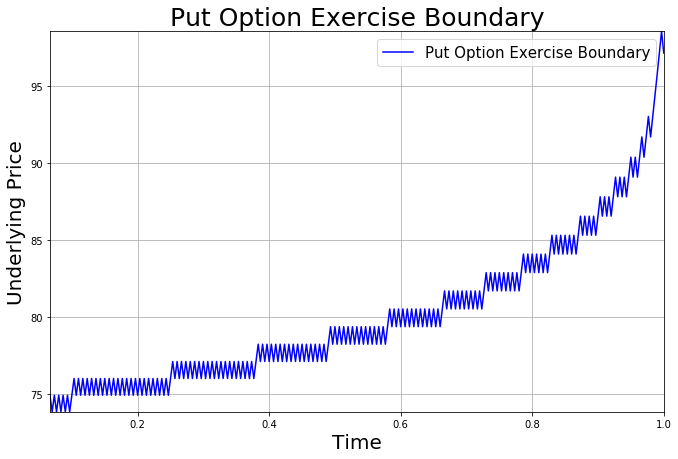

European Price = 7.459
American Price = 7.971


In [3]:
from rl.gen_utils.plot_funcs import plot_list_of_curves
spot_price_val: float = 100.0
strike: float = 100.0
is_call: bool = False
expiry_val: float = 1.0
rate_val: float = 0.05
vol_val: float = 0.25
num_steps_val: int = 300

if is_call:
    opt_payoff = lambda _, x: max(x - strike, 0)
else:
    opt_payoff = lambda _, x: max(strike - x, 0)

opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val
)

vf_seq, policy_seq = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())
ex_boundary: Sequence[Tuple[float, float]] = \
    opt_ex_bin_tree.option_exercise_boundary(policy_seq, is_call)
time_pts, ex_bound_pts = zip(*ex_boundary)
label = ("Call" if is_call else "Put") + " Option Exercise Boundary"
plot_list_of_curves(
    list_of_x_vals=[time_pts],
    list_of_y_vals=[ex_bound_pts],
    list_of_colors=["b"],
    list_of_curve_labels=[label],
    x_label="Time",
    y_label="Underlying Price",
    title=label
)

european: float = opt_ex_bin_tree.european_price(is_call, strike)
print(f"European Price = {european:.3f}")

am_price: float = vf_seq[0][0]
print(f"American Price = {am_price:.3f}")

In [16]:
# Only work for days!!! no continuous time!!!! What can expiry be a float?
@dataclass(frozen=True)
class OptimalExerciseContinuous:

    spot_price: float
    payoff: Callable[[float, float], float]
    price_movement: Callable[[float],float]
    expiry: int
    rate: float
    vol: float
    gamma: float
    init_fa: Sequence[FunctionApprox[float]]

    def european_price(self, is_call: bool, strike: float) -> float:
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        if is_call:
            ret = self.spot_price * norm.cdf(d1) - \
                strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2)
        else:
            ret = strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - \
                self.spot_price * norm.cdf(-d1)
        return ret
    
    
    def get_mdp(self, t: int) -> MarkovDecisionProcess[float, float]:
        """
        State is price of the underlying, Action is whether to sell
        """


        class AmericanOptionMDP(MarkovDecisionProcess[float, float]):

            def step(
                self,
                underlying: float,
                sell: int
            ) -> SampledDistribution[Tuple[float, float]]:

                def sr_sampler_func(
                    p=underlying,
                    a=sell
                ) -> Tuple[float, float]:
                    next_p: float = self.price_movement(p)
                    if t == self.expiry - 1 or a == 1:
                        reward = self.payoff(t, next_p)
                    else:
                        reward = 0.
                    return (next_wealth, reward)

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=1000
                )

            def actions(self, underlying: float) -> Sequence[float]:
                return [0,1]

        return AmericanOptionMDP()
  
    def get_states_distribution(t:int) -> SampledDistribution[float]:
        actions_distr: Choose[float] = self.uniform_actions()

        def states_sampler_func() -> float:
            wealth: float = self.spot_price
            for i in range(t):
                wealth = self.price_movement(wealth)
            return wealth

        return SampledDistribution(states_sampler_func)

    
    def backward_induction_vf_and_pi(
        self
    ) -> Iterator[Tuple[FunctionApprox[float], Policy[float,int]]]:

        mdp_f0_mu_triples: Sequence[Tuple[
            MarkovDecisionProcess[float],
            FunctionApprox[float],
            SampledDistribution[float]
        ]] = [(
            self.get_mdp(i),
            self.init_fa,
            self.get_states_distribution(i)
        ) for i in range(self.expiry)]

        num_state_samples: int = 300
        error_tolerance: float = 1e-8

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            gamma=self.gamma,
            num_state_samples=num_state_samples,
            error_tolerance=error_tolerance
        )